In [50]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Density = pd.read_csv('~/Documents/NYCDSA/Capstone/Density_Atlanta/Density_Atlanta.csv')
Atlanta_Density['TotalBath'] = Atlanta_Density['number_of_full_baths'] + (Atlanta_Density['number_of_half_baths']*0.5)
Atlanta_Density = Atlanta_Density.drop(columns=['ID', 'source_property_id', 'year_built', 'source_name',
                                                  'listing_date', 'mls_id', 'census_zcta5_geoid',
                                                  'census_cbsa_geoid', 'latitude', 'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths'])
Atlanta_Density = Atlanta_Density.rename(columns={'SM_One': 'Supermarket (One Mile)', 'C_One': 'Convenience (One Mile)',
'WS_One': 'Wholesale (One Mile)', 'VS_One': 'Variety Store (One Mile)', 'SC_One': 'Supercenter (One Mile)', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                   'lot_size_in_square_feet': 'Lot Size(SQF)', 'number_of_garage_spaces': 'Garage Spaces', 'number_of_stories': 'Stories',
                                                   'SM_Five': 'Supermarket (Five Miles)', 'C_Five': 'Convenience (Five Miles)',
'WS_Five': 'Wholesale (Five Miles)', 'VS_Five': 'Variety Store (Five Miles)', 'SC_Five': 'Supercenter (Five Miles)'})
Atlanta_Density_One = Atlanta_Density.drop(columns=['Wholesale (Five Miles)', 'Variety Store (Five Miles)', 'Supermarket (Five Miles)', 'Supercenter (Five Miles)', 'Convenience (Five Miles)'])
Atlanta_Density_One

,street_address,city,state,current_listing_price,Total Bedrooms,Living Area(SQF),Lot Size(SQF),has_pool,has_garage,Garage Spaces,Stories,story_indicator,Wholesale (One Mile),Variety Store (One Mile),Supermarket (One Mile),Supercenter (One Mile),Convenience (One Mile),TotalBath
0,0 ivy MNR DR NW 0,Marietta,GA,2865,4,3259.0,14810.400390,False,True,NaN,2.0,Multi,0,0,0,0,0,2.5
1,1 10 buena VIS CIR SE,Cartersville,GA,2200,3,1993.0,NaN,False,False,NaN,NaN,NaN,0,2,0,1,2,2.0
2,1 1088 coldwater DR,Griffin,GA,2000,3,1910.0,NaN,False,True,NaN,NaN,NaN,0,0,0,0,0,2.0
3,1 1130 willivee DR,Decatur,GA,1995,3,1134.0,NaN,False,False,NaN,NaN,NaN,0,0,0,0,0,1.0
4,1 1307 idlewood CT,Mcdonough,GA,2800,4,2532.0,NaN,False,True,NaN,NaN,NaN,0,0,0,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21021,procurement only - 66 4th ST,Newnan,GA,1600,3,1367.0,NaN,False,True,NaN,NaN,NaN,0,0,0,0,0,2.0
21022,r2188 executive DR,Duluth,GA,2199,3,1696.0,871.199981,False,False,NaN,NaN,NaN,0,0,1,0,1,2.5
21023,r3339 woodward down,Buford,GA,2380,3,1944.0,4356.000065,False,False,NaN,NaN,NaN,1,1,1,1,0,3.5
21024,singleunit 216 greensprings DR,Palmetto,GA,1900,4,1204.0,NaN,False,False,NaN,NaN,NaN,0,1,0,0,1,2.0


In [51]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Density_One.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [52]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Density_One)

In [53]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Total Bedrooms',
 'Living Area(SQF)',
 'Lot Size(SQF)',
 'Garage Spaces',
 'Stories',
 'Wholesale (One Mile)',
 'Variety Store (One Mile)',
 'Supermarket (One Mile)',
 'Supercenter (One Mile)',
 'Convenience (One Mile)',
 'TotalBath']

In [54]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Total Bedrooms,Living Area(SQF),Lot Size(SQF),Garage Spaces,Stories,Wholesale (One Mile),Variety Store (One Mile),Supermarket (One Mile),Supercenter (One Mile),Convenience (One Mile),TotalBath
0,0.641572,1.314402,-0.032974,-7.852071e-16,0.00498,-0.093701,-0.411516,-0.527845,-0.229586,-0.376832,0.050733
1,-0.459448,0.111674,0.000000,-7.852071e-16,0.00000,-0.093701,2.854824,-0.527845,3.756596,1.972893,-0.167403
2,-0.459448,0.032822,0.000000,-7.852071e-16,0.00000,-0.093701,-0.411516,-0.527845,-0.229586,-0.376832,-0.167403
3,-0.459448,-0.704394,0.000000,-7.852071e-16,0.00000,-0.093701,-0.411516,-0.527845,-0.229586,-0.376832,-0.603676
4,0.641572,0.623736,0.000000,-7.852071e-16,0.00000,-0.093701,-0.411516,-0.527845,-0.229586,-0.376832,-0.167403
...,...,...,...,...,...,...,...,...,...,...,...
21021,-0.459448,-0.483039,0.000000,-7.852071e-16,0.00000,-0.093701,-0.411516,-0.527845,-0.229586,-0.376832,-0.167403
21022,-0.459448,-0.170482,-0.033370,-7.852071e-16,0.00000,-0.093701,-0.411516,0.857559,-0.229586,0.798031,0.050733
21023,-0.459448,0.065123,-0.033271,-7.852071e-16,0.00000,10.672215,1.221654,0.857559,3.756596,-0.376832,0.487006
21024,0.641572,-0.637893,0.000000,-7.852071e-16,0.00000,-0.093701,1.221654,-0.527845,-0.229586,0.798031,-0.167403


In [55]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Target variable
y = Atlanta_Density_One['current_listing_price']
# All features
X = Atlanta_Density_One.drop(columns='current_listing_price')
models = LinearRegression()

coefficients_list = []
intercepts_list = []
scores = []
# Perform the KFold cross-validation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models),
])
# Initialize the linear regression model
# Fit the model on the training data
pipeline.fit(Atlanta_Density_One.drop(columns='current_listing_price'), Atlanta_Density_One['current_listing_price'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Total Bedrooms', 'Living Area(SQF)', 'Lot Size(SQF)', 'Garage Spaces',
       'Stories', 'Wholesale (One Mile)', 'Variety Store (One Mile)',
       'Supermarket (One Mile)', 'Supercenter (One Mile)',
       'Convenience (One Mile)', 'TotalBath'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [56]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
scores = cross_val_score(pipeline, X, y, scoring = 'r2', cv=kf, n_jobs = -1)
scores
np.mean(scores)

-0.33492128839222557

In [12]:
# Find the best score (maximum R^2 score)
best_score = scores.max()

print("Best R^2 score from cross-validation:", best_score)
print('Variance:',np.var(scores))

Best R^2 score from cross-validation: 0.32808170470966813
Variance: 3.2922455232956174


In [13]:
fold_scores = []
fold_num = 1
for train_index, test_index in kf.split(Atlanta_Density_One):
    X_train, X_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train, y_train)
    fold_score = pipeline.score(X_test, y_test)
    print(f'Score for Fold: {fold_num}', fold_score)
    fold_scores.append({
        'score':fold_score,
        'fold':fold_num})
    fold_num += 1

Score for Fold: 1 0.21392862632366316
Score for Fold: 2 0.24650085232695218
Score for Fold: 3 0.11302236415452793
Score for Fold: 4 0.27330445619463095
Score for Fold: 5 0.32361203194091903
Score for Fold: 6 0.3164764597915879
Score for Fold: 7 0.32808170470966813
Score for Fold: 8 0.31382410138076144
Score for Fold: 9 -5.775026305479042
Score for Fold: 10 0.29706282473407475


In [14]:
import statsmodels.api as sm
x = sm.add_constant(transformed_df)
y = list(Atlanta_Density_One['current_listing_price'])
model= sm.OLS(y, x)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
results = model.fit()
results.model.data.xnames = ['const'] + all_feature_names
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     717.2
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:08:07   Log-Likelihood:            -1.6977e+05
No. Observations:               21026   AIC:                         3.396e+05
Df Residuals:                   21014   BIC:                         3.397e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [15]:
coefficients = results.params
print(coefficients)

const                       2272.475174
Total Bedrooms               273.189457
Living Area(SQF)             229.913628
Lot Size(SQF)                  1.765739
Garage Spaces                 18.910591
Stories                       11.706811
Wholesale (One Mile)          10.233756
Variety Store (One Mile)     -40.597709
Supermarket (One Mile)       139.474264
Supercenter (One Mile)         2.717832
Convenience (One Mile)       141.086600
TotalBath                     71.802815
dtype: float64


In [20]:
# Scores array
scores = [0.21392863, 0.24650085, 0.11302236, 0.27330446, 0.32361203, 
          0.31647646, 0.3280817, 0.3138241, -5.77502631, 0.29706282]

# Creating a DataFrame with fold numbers and scores
df_scores = pd.DataFrame({
    'Fold': [f'F{i+1}' for i in range(len(scores))],
    'Score': scores
})

data = [['F1', 0.21392863], 
        ['F2', 0.24650085], 
        ['F3', 0.11302236], 
        ['F4', 0.27330446], 
        ['F5', 0.32361203],
        ['F6', 0.31647646], 
        ['F7', 0.3280817], 
        ['F8', 0.3138241],  
        ['F10', 0.29706282]]

df = pd.DataFrame(data, columns=['Fold', 'Score'])

df

,Fold,Score
0,F1,0.213929
1,F2,0.246501
2,F3,0.113022
3,F4,0.273304
4,F5,0.323612
5,F6,0.316476
6,F7,0.328082
7,F8,0.313824
8,F10,0.297063


C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


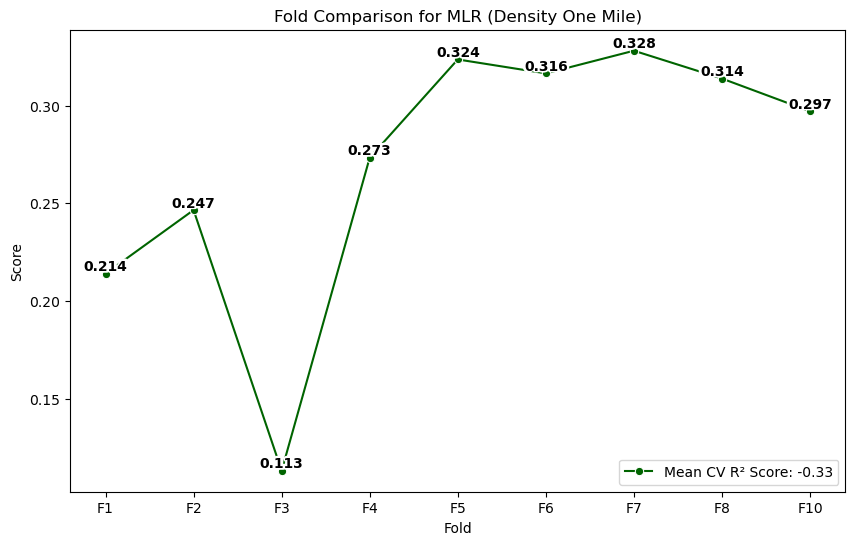

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects

# Creating a seaborn line plot with dark green color
plt.figure(figsize=(10, 6))
sns.lineplot(x='Fold', y='Score', data=df, marker='o', color='darkgreen')

# Annotating each point with bold font and white outline
for i, score in enumerate(df['Score']):
    # White outline (larger text in white)
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='white', 
             path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="white")])
    # Bold, dark text on top
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding labels and title
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Fold Comparison for MLR (Density One Mile)')
plt.grid(False)

plt.legend(labels=['Mean CV R² Score: -0.33'], loc='lower right')

# Display the plot
plt.show()

In [46]:
Atlanta_Density_Five = Atlanta_Density.drop(columns=['Wholesale (One Mile)', 'Variety Store (One Mile)', 'Supermarket (One Mile)', 'Supercenter (One Mile)', 'Convenience (One Mile)'])
numeric_features = Atlanta_Density_Five.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Density_Five)

In [47]:
# Combine all feature names
all_feature_names = list(numeric_features)
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)

In [48]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Target variable
y = Atlanta_Density_Five['current_listing_price']
# All features
X = Atlanta_Density_Five.drop(columns='current_listing_price')
models = LinearRegression()

coefficients_list = []
intercepts_list = []
scores = []
# Perform the KFold cross-validation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models),
])
# Initialize the linear regression model
# Fit the model on the training data
pipeline.fit(Atlanta_Density_Five.drop(columns='current_listing_price'), Atlanta_Density_Five['current_listing_price'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Total Bedrooms', 'Living Area(SQF)', 'Lot Size(SQF)', 'Garage Spaces',
       'Stories', 'Wholesale (Five Miles)', 'Variety Store (Five Miles)',
       'Supermarket (Five Miles)', 'Supercenter (Five Miles)',
       'Convenience (Five Miles)', 'TotalBath'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [49]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, Atlanta_Density_Five.drop(columns='current_listing_price'), Atlanta_Density_Five['current_listing_price'], scoring = 'r2', cv=kf, n_jobs = -1)
best_score = scores.max()
print("Best R^2 score from cross-validation:", best_score)
print('Variance:',np.var(scores))
scores
np.mean(scores)

Best R^2 score from cross-validation: 0.4034201564014236
Variance: 1.3365419105075889


-0.030502594269174253

In [42]:
fold_scores = []
fold_num = 1
for train_index, test_index in kf.split(Atlanta_Density_One):
    X_train, X_test = X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train, y_train)
    fold_score = pipeline.score(X_test, y_test)
    print(f'Score for Fold: {fold_num}', fold_score)
    fold_scores.append({
        'score':fold_score,
        'fold':fold_num})
    fold_num += 1

Score for Fold: 1 0.3223630165240474
Score for Fold: 2 0.34321583353669727
Score for Fold: 3 0.4034201564014236
Score for Fold: 4 0.38666681309262085
Score for Fold: 5 0.37149074267814686
Score for Fold: 6 0.3770796430290577
Score for Fold: 7 0.26326834371964924
Score for Fold: 8 0.3892044897280327
Score for Fold: 9 0.3350500814923013
Score for Fold: 10 -3.4967850628937196


In [43]:
import statsmodels.api as sm
x = sm.add_constant(transformed_df)
y = list(Atlanta_Density_One['current_listing_price'])
model= sm.OLS(y, x)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
results = model.fit()
results.model.data.xnames = ['const'] + all_feature_names
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     1091.
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        01:24:41   Log-Likelihood:            -1.6837e+05
No. Observations:               21026   AIC:                         3.368e+05
Df Residuals:                   21014   BIC:                         3.369e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [36]:
# Scores array
scores = [ 0.32236302,  0.34321583,  0.40342016,  0.38666681,  0.37149074,
        0.37707964,  0.26326834,  0.38920449,  0.33505008, -3.49678506]

# Creating a DataFrame with fold numbers and scores
df_scores = pd.DataFrame({
    'Fold': [f'F{i+1}' for i in range(len(scores))],
    'Score': scores
})

data = [['F1', 0.32236302], 
        ['F2', 0.34321583], 
        ['F3', 0.40342016], 
        ['F4', 0.38666681], 
        ['F5', 0.37149074],
        ['F6', 0.37707964], 
        ['F7', 0.26326834], 
        ['F8', 0.38920449],  
        ['F9', 0.33505008]]

df = pd.DataFrame(data, columns=['Fold', 'Score'])

C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


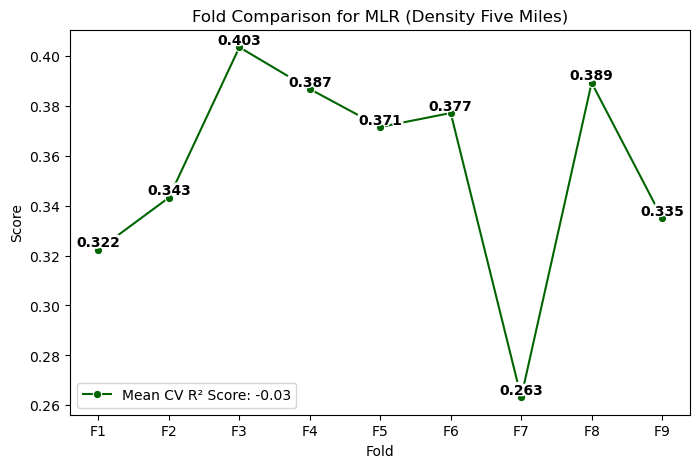

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects

# Creating a seaborn line plot with dark green color
plt.figure(figsize=(8, 5))
sns.lineplot(x='Fold', y='Score', data=df, marker='o', color='darkgreen')

# Annotating each point with bold font and white outline
for i, score in enumerate(df['Score']):
    # White outline (larger text in white)
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='white', 
             path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="white")])
    # Bold, dark text on top
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding labels and title
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('Fold Comparison for MLR (Density Five Miles)')
plt.grid(False)

plt.legend(labels=['Mean CV R² Score: -0.03'], loc='lower left')

# Display the plot
plt.show()